Import all necessary Packages

In [1]:
import random
from IPython.display import clear_output
import time
from scipy import array, newaxis
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.interpolate import interp2d


Initiate the character map, specify the tile class and house class.

In [2]:

character_map = {0:"👍",1:"👎",2:"💩",'W':"💀", 'bot':"🤖"}

class tile():
  def __init__(self, position, cleanliness=0, wall = False, bot = False):
    #Capture the directions to the left, right, bottom and top as per Von Neumann neighbourhoods.
    #Capture the cleanliness, positions and also markers for visits and if the bot is on the cell
    self.position = position
    self.cleanliness = cleanliness
    self.right = (position[0],position[1]+1)
    self.left = (position[0],position[1]-1)
    self.bottom = (position[0]+1,position[1])
    self.top = (position[0]-1,position[1])
    self.bot = False
    self.visit = 0
    
  
class house_c(tile): 
  def __init__(self, obstacles = 5, dimensions = (15,15), mess = "Very Dirty"):
    self.dimensions = dimensions
    self.house = house = [[0]*dimensions[1] for row in range(dimensions[0])]
    self.walls = 3
    self.obstacles = obstacles
    self.mess = mess
  
  def add_walls(self):
    #To keep things simple, we just add walls on horizontal walls with at most half the room length
    half_length = self.dimensions[1]//2
    #generate 3 random walls that dont coincide with the house walls so betweeen dimension-1, non inclusive
    wall_rows = random.sample(range(2, self.dimensions[1]-1),min(self.obstacles, half_length))
    for row in wall_rows:
      #Spawn a wall of randomlength between 1 and half_length. We limit walls to a minimum 2 length
      wall_length = random.randint(2, half_length)
      #Starting position for the wall. It must be before the midroom so any wall fits
      start_pos = random.randint(0, self.dimensions[1]//2)
      for tile in range(start_pos, start_pos+wall_length):
        self.house[row][tile].wall = True
        self.house[row][tile].cleanliness = "W"
    return None    
  
 
  #This function spawns a house. By defaultm the house cleanliness is dirty in case the option selected is wrong.
  #We populate the tiles with a cleanliness leve as specified by the use.
  def spawn_house(self):
    clean = 2
    for row in range(self.dimensions[1]):
      for cell in range(self.dimensions[0]):
        #Make the house messy
        if self.mess == "Very Dirty":
          pass
        elif self.mess == "Random":
          clean = random.randint(0,2)
        elif self.mess == "Slightly Clean":
          clean = 1
        elif self.mess == "Clean":
          clean = 0
        self.house[cell][row] = tile(position = (cell, row), cleanliness = clean)
    self.add_walls()
    return self.house
  
  #A string method to output the house as per the character map.
  def __str__(self):
    full = []
    for row in self.house:
      cur_row = []
      for tile in row:
        if not tile.bot:
          cur_row.append(character_map[tile.cleanliness])
        else:
          cur_row.append(character_map["bot"])
      full.append("".join(cur_row))
    print("########## WELCOME TO MY HOUSE! ###########")
    print(f"It is {self.mess}")
    print("And be careful, the walls have ears, literally.\n")
    return "\n".join(full)
    
  

 

This is an initialization of the roomba class. It needs to know the house it is serving. Some utility functions are included to help when programming the bot.

In [3]:
class roomba():
  #Initiate the roomba bot. 
  #Markers for the strategies like random bounce and wall walking are specified.
  def __init__(self, house, wall_walking = True, random_bounce = True, start = (0,0), delay =1,minimum_visits = True):
    self.wall_walking = wall_walking
    self.random_bounce = random_bounce
    self.start = start
    self.house = house
    self.movement = {"Right":(0,1), "Left":(0, -1), "Top":(-1, 0), "Bottom":(1, 0), "Current":(0,0)}
    self.direction = None
    self.delay = delay
    self.minimum_visits = minimum_visits
    self.count_steps = 0
  """
  -This utility function determines the level of cleanliness of the house. 
  -A roomba user can determine this then program the roomba to run tiil it feels it
  -has collected as much dirt to leave the room in a cleanliness proportion specified.
  """
  def check_clean(self):
    dirt = 0
    for row in self.house.house:
      for tile in row:
        if tile.cleanliness !="W":
          try:
            dirt+=int(tile.cleanliness)
          except:
            pass
    return dirt
  """  
  -This utility function gets the roomba position and tells it where it can go. 
  -Depending on activated strategies, it can favor wall crawling or random bouncing or both. 
  -The situations are discussed in tha paper/
  """
  def possible_directions(self, bot_position):
    feasible = {"Current":bot_position}
    neighbor_clean = {"Current":self.house.house[bot_position[0]][bot_position[1]].cleanliness}
    direction = None
    #There are only 4 possible directions
    direction_keys = list(self.movement.keys())
    
    for direction in direction_keys:
      next_row = bot_position[0]+self.movement[direction][0]
      next_col = bot_position[1]+self.movement[direction][1]
      """
      -If the tiles are outside the house span, we will skip them
      -Nonetheless, these are our wall markers so we might want to keep track of the wally neighbors so as to follow them
      """
      if next_row <0 or next_col <0 or  next_row >=self.house.dimensions[0] or next_col>=self.house.dimensions[1]:
        continue
      
      else:
        """
        -If the tiles are withn the span are walls, we will skip them, otherwise we can move to them
        -We move at random whether the floor is clean or not but focus will force us to sty if a tile is too dirty
        """
        next_tile_cleanliness = self.house.house[next_row][next_col].cleanliness
        
        if next_tile_cleanliness is not "W":
          feasible[direction] = (next_row, next_col)
          neighbor_clean[direction] = self.house.house[next_row][next_col].cleanliness
          
    #For efficiency, if there are any neighbors dirty, we will not visit clean neighbors again thus prioritizing dirty spots
    if sum(list(neighbor_clean.values()))>0:
      #Random bounce tells the system to jump to a random dirty cell if any. Otherwise move in a random direction
      if self.random_bounce:
        for direction in list(feasible.keys()):
          if neighbor_clean[direction] == 0:
            del feasible[direction]
      
      #Atop the clean elimination, if wall following is enabled, we will favor the wall direction if no dirty tile is seen.
      priority = []
      """
      -Under the same constraint, if wall walkingis enabled, we basicallt prioritize the directions
      -That walk the wall in the feasible set and eliminate the others.
      -Affinity for dirty preceeds the wall walk either way so if we encounter a dirty cell not on the wall
      -and a cleaner one ahead, we will stop the wall walk. This is if
      """
      if self.wall_walking:
        if len(feasible)>1:
          for direction in list(feasible.keys()):
            next_row = bot_position[0]+self.movement[direction][0]
            next_col = bot_position[1]+self.movement[direction][1]
            if direction =="Top" or direction == "Bottom":
              if bot_position[1]+1>=self.house.dimensions[1] or bot_position[1]-1<0 or self.house.house[bot_position[0]][bot_position[1]+1].cleanliness == 'W' or self.house.house[bot_position[0]][bot_position[1]-1].cleanliness == 'W':
                priority.append(direction)
            
            elif direction == "Right" or direction == "Left":
              if bot_position[0]+1>=self.house.dimensions[0] or  bot_position[0]-1<0 or self.house.house[bot_position[0]+1][bot_position[1]].cleanliness=="W" or self.house.house[bot_position[0]-1][bot_position[1]].cleanliness=="W":
                priority.append(direction)
        
      """
      -A check to ensure we limit our options to sensible ones. 
      -The bot behaves randomly when in a clean room since the sum of neighbors cleanlines is 0
      -This means they have no dirtiness.  
      """
      if len(priority)<len(feasible) and len(priority)>0:
        for direction in list(feasible.keys()):
          if direction in priority:
            continue
          else:
            del feasible[direction]
    return (feasible, neighbor_clean)
  
  #A utility function to produce a heatmap.
  def heatmap(self):
      x_list = [x for x in range(self.house.dimensions[1])]
      y_list = [y for y in range(self.house.dimensions[0])]
      z_list = []
      for ys in y_list:
        for xs in x_list:
          z_list.append(house1.house[xs][ys].visit)

      
      f = interp2d(x_list,y_list,z_list,kind="linear")

      x_coords = np.arange(min(x_list),max(x_list)+1)
      y_coords = np.arange(min(y_list),max(y_list)+1)
      Z = f(x_coords,y_coords)
      figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
      fig = plt.imshow(Z,
                 extent=[min(x_list),max(x_list),min(y_list),max(y_list)],
                 origin="lower")

      fig.axes.set_autoscale_on(False)
      plt.scatter(x_list,y_list,400,facecolors='none')
      plt.gca().invert_yaxis()
      plt.show()
  
  """
  This function initiates the movement.
  -Parameters such as focus tell us if we stick to a dirty cell untill it is clean.
  -Clean level is the goal state of how clean we want our house. This gives the bot 
  -an idea of how much cleaning it will have done till it stops.
  -Blink is for when we want an animated version of the bot in action.
  -Out_steps is the steps moved before we show the state currently we are in.
  -Have a high out_step for big houses to limit the output. 
  """
  def initiate_traversal(self, focus,fin, clean_level, blink =True, heatmap = True, out_steps=20):
    #Check how clean the house is
    dirt = self.check_clean()
    original = dirt
    target_clean = dirt*clean_level
    count_steps = 0
    #Run till we feel we have collected enough dirt to make the room clean to desired levels.
    while target_clean<dirt:
      proportion_cleaned = dirt/original
      #Get the current bot tile as is
      bot_tile = self.house.house[self.start[0]][self.start[1]]
      #Put the bot in starting tile
      self.house.house[self.start[0]][self.start[1]].bot = True
      self.house.house[self.start[0]][self.start[1]].visit +=1
      next_data = self.possible_directions(bot_tile.position)
      possible_directions = next_data[0]
      
      """
      -Minimum visits is my proposed third setting.This tells the bot to favor visiting cells it
      -Has not visited yet. It especially helps prevent sticking too much in a clean patch.
      -If the bot stays in a place for too long, it eventually favors moving away as it detects this.
      """
      if self.minimum_visits:
        min_vals = list(possible_directions.values())[0]
        min_vis = self.house.house[min_vals[0]][min_vals[1]].visit
        for direc in list(possible_directions.keys()):
          cur_vis = self.house.house[possible_directions[direc][0]][possible_directions[direc][1]].visit
          if cur_vis<=min_vis:
            direction = direc
            min_vis = cur_vis
      else:
        #Otherwise, we will move in a random direction
        direction = random.choice(list(possible_directions.keys()))
      if focus:
        #Focus is for when we want to clean any dirty patch to completion
        if self.house.house[self.start[0]][self.start[1]].cleanliness >0:
          direction = "Current"
          self.house.house[self.start[0]][self.start[1]].visit +=2
          
      else:
        del possible_directions["Current"]
      
        
      #Clean bot tile then move bot in direction specified
      self.house.house[self.start[0]][self.start[1]].cleanliness = max((int(bot_tile.cleanliness)-1),0)
      #Blink check
      if blink:
        clear_output()
      
      #Output checks
      if count_steps%out_steps == 0 or proportion_cleaned==0:  
        if fin:
            print(f"Proportion Remaining = {proportion_cleaned}")
            print(f"Possible directions: {possible_directions}")
            print(self.house)
      
      #Heatmap checks
      if heatmap and count_steps%out_steps == 0 or proportion_cleaned==0:
        self.heatmap()
        print(f"\nNext step direction: {direction}")
      self.house.house[self.start[0]][self.start[1]].bot = False
      self.start = (self.start[0]+self.movement[direction][0], self.start[1]+self.movement[direction][1])
      #A delay that facilitates the blink system
      if blink and count_steps%out_steps == 0 or proportion_cleaned==0:
        time.sleep(self.delay)
      dirt =  self.check_clean()
      count_steps+=1
    self.count_steps = count_steps
  
    
    
    
    
  #Our parent function that initiates the cleaning and tells us the final state.
  def clean(self,clean_level, focus,blink =True, heatmap = True, out_steps=20, fin = True):    
      self.initiate_traversal(focus = focus, clean_level = clean_level, blink =blink, heatmap = heatmap,  out_steps=out_steps, fin=fin)
      if fin:
          print("FINAL STATE OF THE HOUSE")
          print(f"Moves made: {self.count_steps}")
          print(self.house)
          self.heatmap()
      return self.count_steps
      

Test Individual Strategies performance

In [4]:
random_bounce = []
wall_walk = []
minimum_visit = []
#Each house will have Its own instance since this is modified during cleaning.
copy1 =  house_c(obstacles = 1, mess = "Random", dimensions  =(10, 10))
copy2 =  house_c(obstacles = 1, mess = "Random", dimensions  =(10, 10))
copy3 =  house_c(obstacles = 1, mess = "Random", dimensions  =(10, 10))
    
for i in range(1000):
    #Spawn a house
    copy1.spawn_house()
    copy2.spawn_house()
    copy3.spawn_house()
    
    #Initiate the roombas
    roombaRB = roomba(house = copy1, delay = 1, start = (0,0),wall_walking =False, 
                 random_bounce = True, minimum_visits = True)
    roombaWW = roomba(house = copy2, delay = 1, start = (0,0),wall_walking =True, 
                 random_bounce = False, minimum_visits = False)
    roombaMV = roomba(house = copy3, delay = 1, start = (0,0),wall_walking =False, 
                 random_bounce = False, minimum_visits = True)
    
    #And lets dance!!!
    rb = roombaRB.clean(clean_level=0, focus =True, blink =False, heatmap = False, out_steps=10000000, fin=False)
    ww = roombaWW.clean(clean_level=0, focus =True, blink =False, heatmap = False, out_steps=10000000, fin=False)
    mv = roombaMV.clean(clean_level=0, focus =True, blink =False, heatmap = False, out_steps=10000000, fin=False)
    
    random_bounce.append(rb)
    wall_walk.append(ww)
    minimum_visit.append(mv)


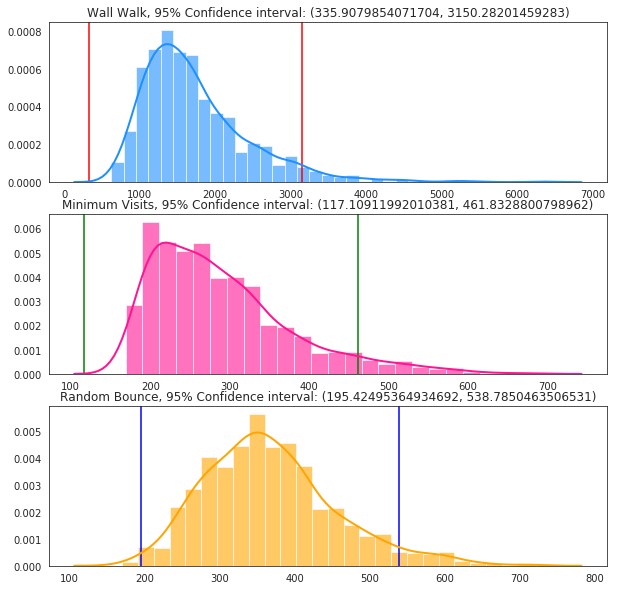

In [6]:
import numpy as np, scipy.stats as stats
import seaborn as sns

def mean_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    return stats.norm.interval(confidence, loc=np.mean(data), scale=np.std(data))

confints_rb = mean_confidence_interval(np.array(random_bounce))
confints_ww = mean_confidence_interval(wall_walk)
confints_mv = mean_confidence_interval(minimum_visit)

sns.set_style("white")

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

fig = plt.figure()
fig.set_size_inches(10, 10)
ax1 = fig.add_subplot(311)
ax1.axvline(x=confints_ww[0], color = "r")
ax1.axvline(x=confints_ww[1], color = "r")
sns.distplot(wall_walk, color="dodgerblue", label="Wall Walk", **kwargs)
ax1.set_title(f"Wall Walk, 95% Confidence interval: {(confints_ww[0], confints_ww[1])}")
ax2 = fig.add_subplot(312)
ax2.axvline(x=confints_mv[0], color = "g")
ax2.axvline(x=confints_mv[1], color = "g")
sns.distplot(minimum_visit, color="deeppink", label="Minimum Visits", **kwargs)
ax2.set_title(f"Minimum Visits, 95% Confidence interval: {(confints_mv[0], confints_mv[1])}")

ax3 = fig.add_subplot(313)
ax3.axvline(x=confints_rb[0], color = "b")
ax3.axvline(x=confints_rb[1], color = "b")
sns.distplot(random_bounce, color="orange", label="Random Bounce", **kwargs)
ax3.set_title(f"Random Bounce, 95% Confidence interval: {(confints_rb[0], confints_rb[1])}")

plt.show()

For our original simulations, these are the histograms

In [7]:
rb = []
ww_rb = []
mv_rb_ww = []

for i in range(1000):   
    #Spawn a house
    copy1.spawn_house()
    copy2.spawn_house()
    copy3.spawn_house()
    
    #Initiate the roombas
    roombaRB = roomba(house = copy1, delay = 1, start = (0,0),wall_walking =False, 
                 random_bounce = True, minimum_visits = False)
    roombaWWRB = roomba(house = copy2, delay = 1, start = (0,0),wall_walking =True, 
                 random_bounce = True, minimum_visits = False)
    roombaMVRBWW = roomba(house = copy3, delay = 1, start = (0,0),wall_walking =True, 
                 random_bounce = True, minimum_visits = True)
    
    #And lets dance!!!
    rbi = roombaRB.clean(clean_level=0, focus =True, blink =False, heatmap = False, out_steps=10000000, fin=False)
    ww_rbi = roombaWWRB.clean(clean_level=0, focus =True, blink =False, heatmap = False, out_steps=10000000, fin=False)
    mv_rb_wwi = roombaMVRBWW.clean(clean_level=0, focus =True, blink =False, heatmap = False, out_steps=10000000, fin=False)
    
    rb.append(rbi)
    ww_rb.append(ww_rbi)
    mv_rb_ww.append(mv_rb_wwi)


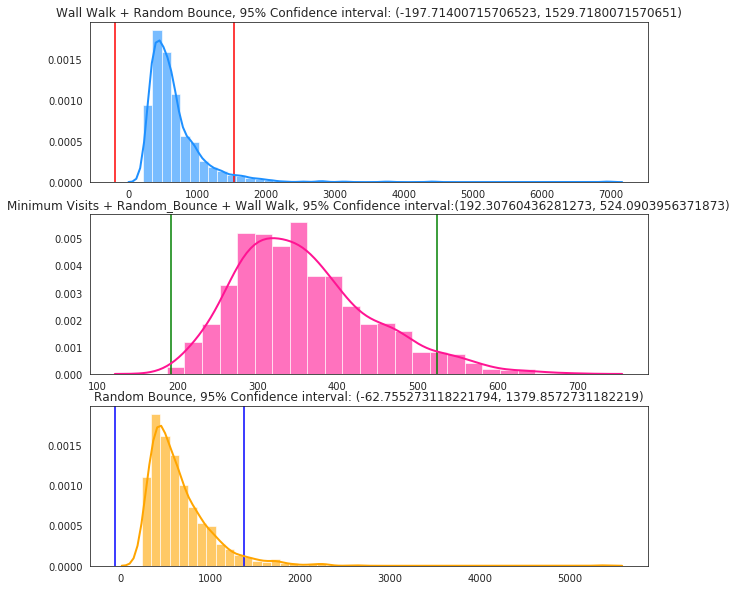

In [8]:
confints_rb = mean_confidence_interval(np.array(rb))
confints_ww = mean_confidence_interval(ww_rb)
confints_mv = mean_confidence_interval(mv_rb_ww)

sns.set_style("white")

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

fig = plt.figure()
fig.set_size_inches(10, 10)
ax1 = fig.add_subplot(311)
ax1.axvline(x=confints_ww[0], color = "r")
ax1.axvline(x=confints_ww[1], color = "r")
sns.distplot(ww_rb, color="dodgerblue", label="Wall Walk", **kwargs)
ax1.set_title(f"Wall Walk + Random Bounce, 95% Confidence interval: {(confints_ww[0], confints_ww[1])}")
ax2 = fig.add_subplot(312)
ax2.axvline(x=confints_mv[0], color = "g")
ax2.axvline(x=confints_mv[1], color = "g")
sns.distplot(mv_rb_ww, color="deeppink", label="Minimum Visits", **kwargs)
ax2.set_title(f"Minimum Visits + Random_Bounce + Wall Walk, 95% Confidence interval:{(confints_mv[0], confints_mv[1])}")

ax3 = fig.add_subplot(313)
ax3.axvline(x=confints_rb[0], color = "b")
ax3.axvline(x=confints_rb[1], color = "b")
sns.distplot(rb, color="orange", label="Random Bounce", **kwargs)
ax3.set_title(f"Random Bounce, 95% Confidence interval: {(confints_rb[0], confints_rb[1])}")

plt.show()

Demonstrations.

1. No minimized visits, no wall walking, just random bounce

Proportion Remaining = 0.011764705882352941
Possible directions: {'Current': (1, 9)}
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍🤖
👍👍👍👍💀💀👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
💀💀👍👍👍👍👍👍👍👍
👍👍👍👍💀💀💀💀💀👍
👍👍👍💀💀👍👍👍👍👍
👍👍👍👍👍💀💀👍👍👍
👍👍👍👍👍👍👍👍👍👍


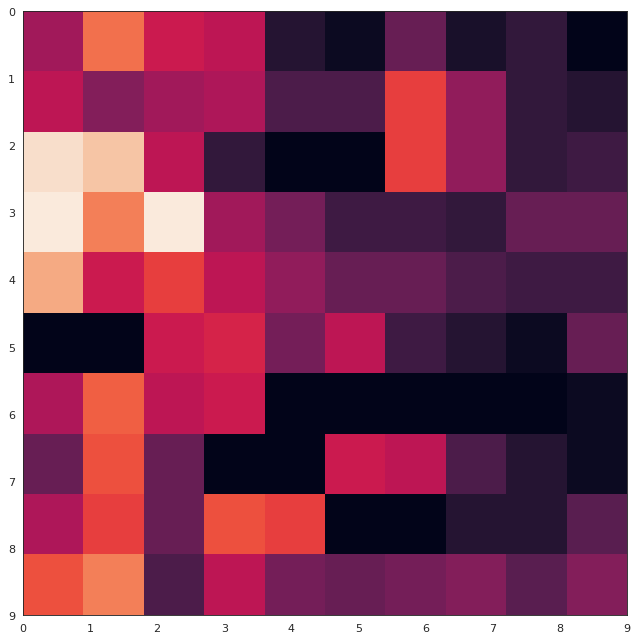


Next step direction: Current
FINAL STATE OF THE HOUSE
Moves made: 778
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍💀💀👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
💀💀👍👍👍👍👍👍👍👍
👍👍👍👍💀💀💀💀💀👍
👍👍👍💀💀👍👍👍👍👍
👍👍👍👍👍💀💀👍👍👍
👍👍👍👍👍👍👍👍👍👍


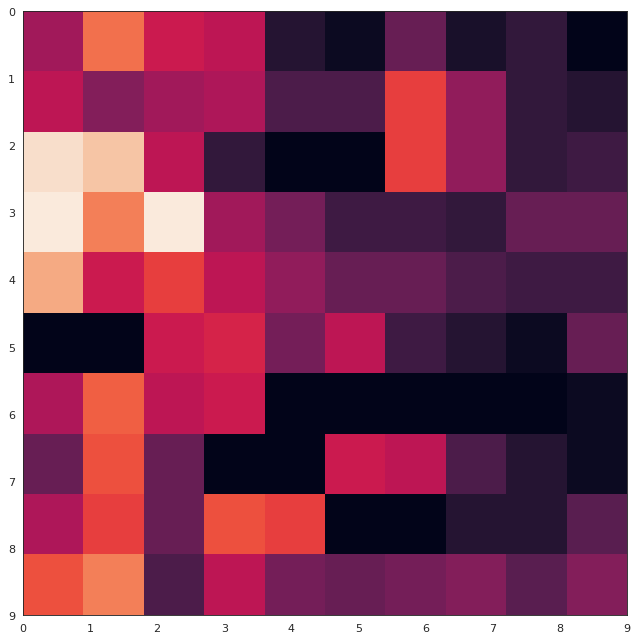

778

In [ ]:
house1 = house_c(obstacles = 5, mess = "Random", dimensions  =(10, 10)) 
house1.spawn_house()


roomba1 = roomba(house = house1, delay = 1, start = (0,0),wall_walking =False, 
                 random_bounce = True, minimum_visits = False)
roomba1.clean(clean_level=0, focus =True, blink =True, heatmap = True, out_steps=1)

Proportion Remaining = 0.011627906976744186
Possible directions: {'Current': (9, 9)}
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍💀💀👍👍👍
💀💀💀💀👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍💀💀💀💀💀👍
👍👍👍👍👍💀💀💀💀👍
👍👍👍👍👍👍👍👍👍👍
👍👍💀💀💀👍👍👍👍👍
👍👍👍👍👍👍👍👍👍🤖


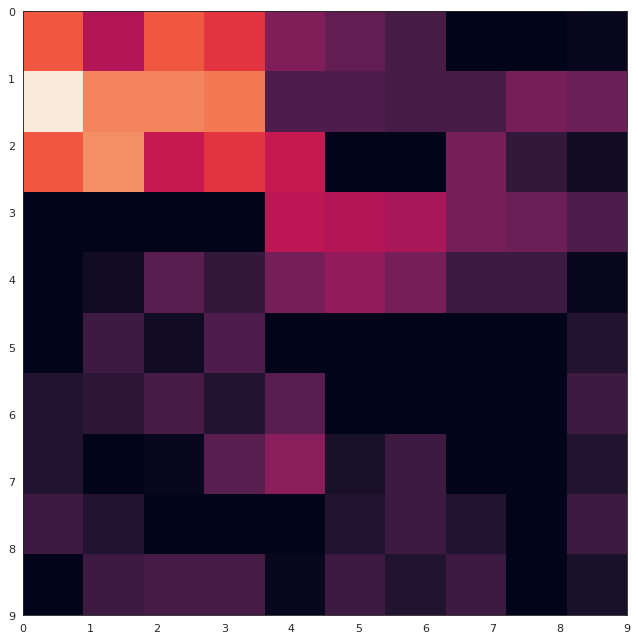


Next step direction: Current
FINAL STATE OF THE HOUSE
Moves made: 656
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍💀💀👍👍👍
💀💀💀💀👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍💀💀💀💀💀👍
👍👍👍👍👍💀💀💀💀👍
👍👍👍👍👍👍👍👍👍👍
👍👍💀💀💀👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍


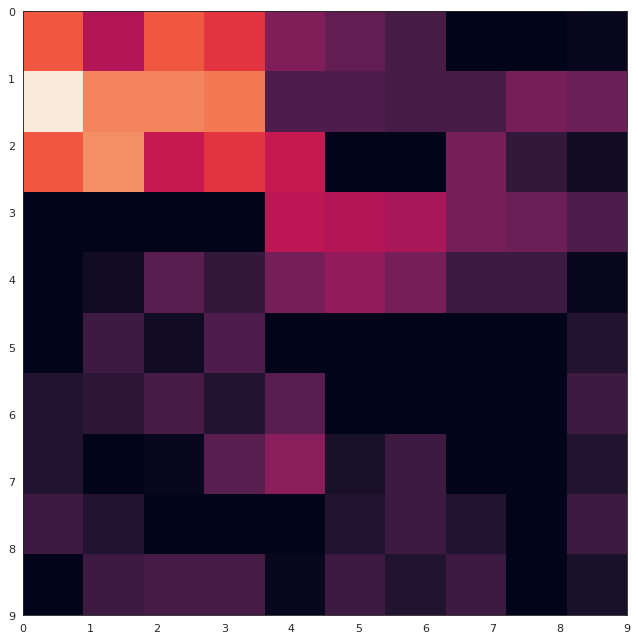

656

In [ ]:
house1 = house_c(obstacles = 5, mess = "Random", dimensions  =(10, 10)) 
house1.spawn_house()


roomba1 = roomba(house = house1, delay = 1, start = (0,0),wall_walking =True, 
                 random_bounce = True, minimum_visits = False)
roomba1.clean(clean_level=0, focus =True, blink =True, heatmap = True, out_steps=1)

Proportion Remaining = 0.05555555555555555
Possible directions: {'Current': (4, 5), 'Right': (4, 6), 'Top': (3, 5), 'Bottom': (5, 5)}
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

👍👍👍👍👎👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍💀💀💀💩👍👍👍👍👍
👍👍💀💀💀👍👍👍👍👍
👍💩💀💀💀🤖👍👍👍👍
👍💀💀👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍💀💀💀👍👍👍👍
👍👍👍👍👍👍👍👍👍👍


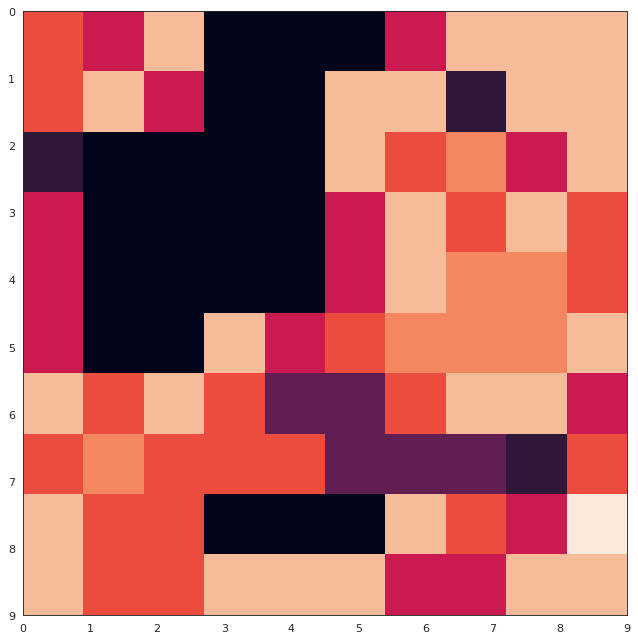


Next step direction: Top


In [ ]:
house1 = house_c(obstacles = 5, mess = "Random", dimensions  =(10, 10)) 
house1.spawn_house()


roomba1 = roomba(house = house1, delay = 1, start = (0,0),wall_walking =True, 
                 random_bounce = True, minimum_visits = True)
roomba1.clean(clean_level=0, focus =True, blink =True, heatmap = True, out_steps=1)

For coverage

**Only Random Bounce**

Proportion Remaining = 1.0
Possible directions: {'Right': (0, 1), 'Bottom': (1, 0)}
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

🤖👎💩👎👍👍👍💩👍💩👍👎👎👎💩💩💩💩👎💩👍💩👍👎👍💩👎💩👎💩👍💩👍👍👎👎👍👍💩💩👎👎💩👍💩👎👍💩👍👎
💩👍💩👎💩👎👍👎💩👎👍👍👎👍👎👎💩👎💩👍👎👍💩👍💩👎💩👍👎👎👎👎👎💩👎👍💩👎💩💩👍👍👎👍💩👍💩💩👎👍
👍👎💩👍👍👍💩💩💩💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💩👍💩💩👍👎👎👎💩👍👎👎👎💩💩👎👍👍👎💩👎
💩👎💩👍👍👎👍👍👎👎💩👎👍👍👍👎👎💩👎💩💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💩👎👍👍💩💩💩
💩💩👍👍👍👎💩👎👍👍👎👎👎💩👎👍💩💀💀💀💀💀💀💀💀💀👎💩💩👎💩👍💩👎💩👍👍💩👍💩💩👍💩👎👍👍👍👍👍💩
💩💩👍💩👎💩👍💩👎👍💩👎👎👍👎👎👎👍👍💩👍👍👍👍👍💩👍👍👍👎👍💩👎💩👎💩👎👎💩💩👍👍👍👍👍💩💩👍👍💩
👎💩💩💩👎👎👎👍💩👎💩💩👎👎👍👍👍👎👎👍👍👎👎👍💩💩👍👍👎👍👍👍👍👎👎👍👍👍👎👎👎👎👍💩👍👍💩👎👎💩
👎💩💩💩👍💩👎👍👍👎💩👍💩💩👍👍👍💩👎👎👎💩💩👎👎💩👍👍👍💩💩💩👎👎👍💩👍💩👎👎👍👎👍👎👍💩👍💩💩👎
💩💩👍👍💩👎💩💩👎👍👎💩👎👎👎💩👎💩💩💀💀💀💀💀💀👍👍👎💩👍👍👎💩👎💩💩👍👍👎👍👎💩💩💩👍💩💩💩👍👍
👍💩👍👍👍👎💩👎👎👎💩👎👎👍👎👍👎👎💩👍💩👎👎👍💩👍👎💩💩💩👍👎👍💩👎💩👍👍👎👍💩👍💩👍👍👎👎👎👎👍
💩👍👍👍👍👍💩👎👍👍💩💩💩👍👍💩👍💩💩👍👍💩💩💩👎👍💩👎👎👍💩👍👍💩💩💩👍💩👎👍👎💩👎👍👍👍💩👍👎👎
👎👎💩👍👎💩💀💀💀💀💀💀👍👍👎👍💩👎💩👍👎👍👎👍👎👎💩💩👎👍👎👍👍👍👍👎💩💩👎💩👎👍💩👎👎👍👎👎💩👎
💩💩💩👎👍👍👍👍👎💩👍💩👎👍👎👍👎💩👍💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💩👎👎👍💩💩💩👍💩
👍👍👎👎💩👍💩👍👍💩👎💩👎👎👎💩💩💩👍💩💩👍👍💩👍💩👍👍👎👎👎💩👎👎👍👍👎💩👍👎👎👎👍👎💩👍👍💩💩💩
👎💩💩👎👍👍👎👍👍👎👎👍💩👍👍👎💩👍💩💩👍👎💩👍💩👎👍👍👎💩💩👍💩💩👎💩💩💩💩👎👍👎💩👎👎👍👍👍💩👍
👎💩👍👎👍👍💩👍👎👍👎👍👍💩👍👎💩👍💩👍👎💀💀💀💀💀💀💀👎👎👍👎💩💩💩💩👎👎👎👍👎👍💩💩💩

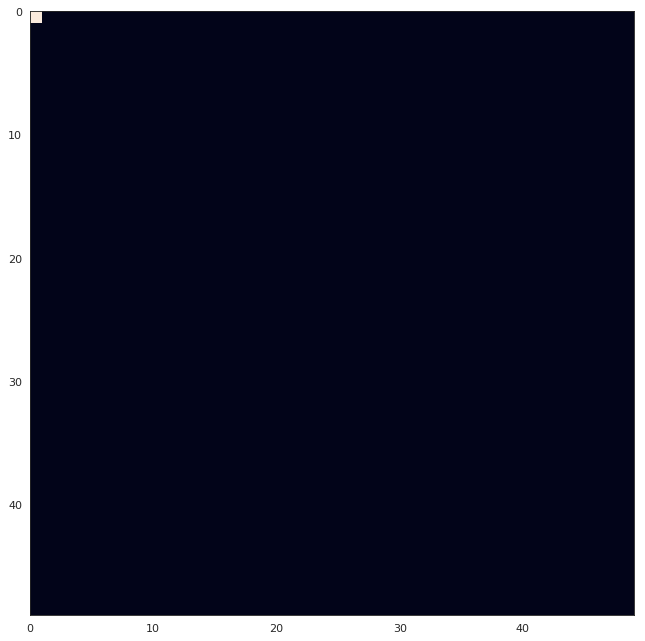


Next step direction: Right
FINAL STATE OF THE HOUSE
Moves made: 185140
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍

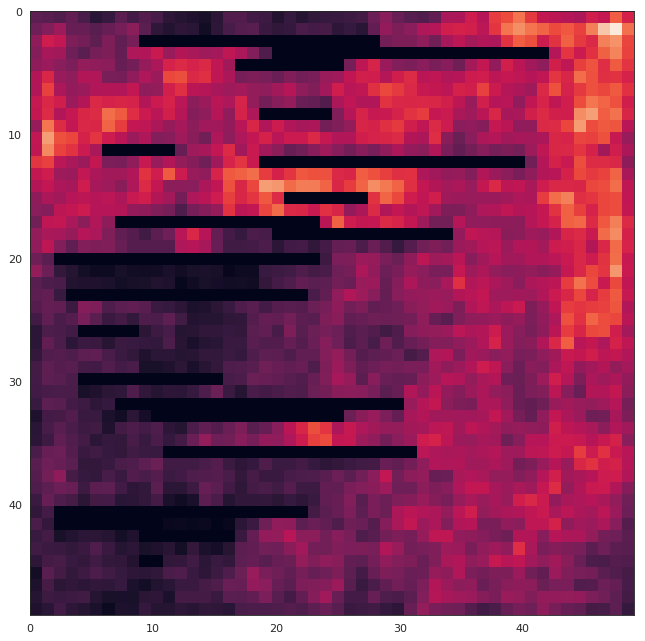

185140

In [11]:
house1 = house_c(obstacles = 20, mess = "Random", dimensions  =(50, 50)) 
house1.spawn_house()


roomba1 = roomba(house = house1, delay = 1, start = (0,0),wall_walking =False, 
                 random_bounce = True, minimum_visits = False)
roomba1.clean(clean_level=0, focus =True, blink =False, heatmap = True, out_steps=1000000000)

**Random Bounce +Wall Walk**

Proportion Remaining = 1.0
Possible directions: {'Right': (0, 1), 'Bottom': (1, 0)}
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

🤖💩👎👎👎💩💩👍👎💩💩👎👍👎💩👎👎💩👍💩👍👍💩👎💩👍👍👍👍💩💩👍💩👎👍👎👎👎💩👎👎👍👍👎👍👍💩👎👍👎
👎👎💩👍👍👍👍💩👍👍👎👍👎💩👍👎👍👍👍👍👎👎💩💩👍👍💩👍👍💩💩👍👍👍💩👍👍👍👍👍💩👎💩👎💩💩💩👎💩👍
👍💩👎👎👎💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💩👍👎👎💩👎💩👍👎👍👎👎💩💩💩💩👎👍👎👍💩💩
💩👍💩👍👍👍💩👎👎👎👍👍👍👎💩💩💩💩💩👍👍👍👎💩💩👍👍👍💩💩👎👎💩👎👍💩👍👍👎👎👍💩💩👎👍👍💩👎💩💩
💩👍👎👎👎👎👎👎👍👎👎💩👍💩👎💀💀💀💀💀💀💀💀💀💀💀👎👎👎💩👍👎👎👎👍👍👎💩👍👍👎👍👍👍👍👎👎👍💩👍
👎👎👎👎👎👍💩👎👎💩👍👎👍👍💩👎💩👍💩👎👍💩💩👎👍👍💩👍💩💩👎👎💩👎👎👍💩👎💩👍👎👍👎👎👎👍👍💩👍👍
👍💩👍👍👍👍💩👎💩💩💩👍👍👎👎👎💩👎👎👎💩👎👍👎💩👎👎👍👎👍👍💩💩💩👎👍👎💩👍👎💩👎💩👎👍👍💩👍💩👍
👍👎💀💀💀💀💀💀💀💀💀💀👎👍👍💩👍💩💩👍👎👍💩💩💩💩💩👍👍💩👍💩👍💩👍💩👍💩💩👍👍💩👎👎👎💩👍👍👎👍
💩👎👍💩👍👎💩💩💩💩👎👍💩👍👎👎👎👍💩👍💩💀💀💩👎👎👍💩💩👍💩👍👎💩👍💩👎💩👍👎💩💩👎👎👍👍💩💩💩👍
👍💩💩💩👎👎👍👍👎👎👍👎👎💩👍👍💩👎💩👍👍👎👍💩💩💩👍💩👎👎👎👍👍👎💩👎👎👍👎💩👍💩💩👍💩👍👍👍👎💩
👎💩💩💩💩👍👎👍👍💩👎👍👎👎💩💩👎👍👎👎👎👍👍👎👎👍👎👎👍👍💩👎👍👎👎👍💩👎👎👎👎👎👎👎💩👎👍👎👎👍
💩👎💩👍👍👎👎💩👍👎👎👍💩💩👍👍💩👎💩👍💩👍👎👍💩💩💩💩👎💩👍👍💩👍👎👎💩💩👍👍💩💩💩👎👍💩👍👍💩👎
👎👎💩👎👎💩💩💩💩👍👍💩👎💩👍👍💀💀💩👎💩💩💩👍💩👎💩💩👍💩👎💩💩👎👎👎👍💩💩👍👎👎💩👍👍👎👎💩💩👎
👍💩👎💩👎💩👎👍👎💩👍👍👍👎💩💩👎👍👍💩👍👎💩👎👎💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀👍
👍💩💩👎💩👎💩👍👍👎👍💩👎👍👎👍👍👎💩👎💩👍👍💩👍👍👍💩👎👍👎💩💩👍👎👍👍👎👎👎💩👎👍👎💩👎👍👍💩👎
💩👎👍👍👍💩👍👍👍💩💩👎💩💩💩💩👎💩👍👍💩💩👍👍👍👍👍💩👎👎👎👎💩💩👎👍👍💩👍👍👍👎👍💩👍

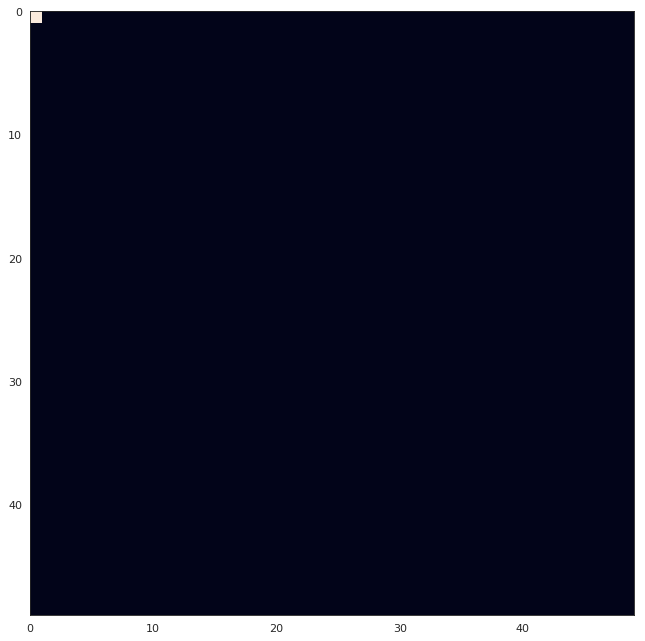


Next step direction: Current
FINAL STATE OF THE HOUSE
Moves made: 79157
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍💀💀💀💀💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍

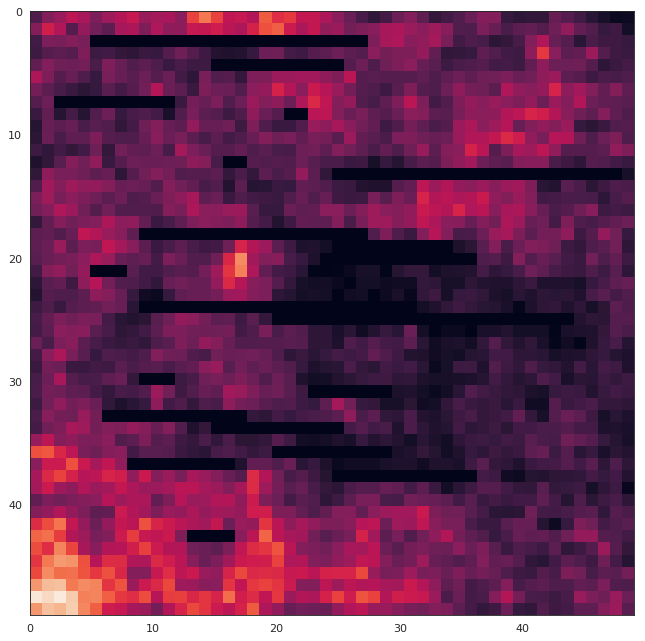

79157

In [10]:
house1 = house_c(obstacles = 20, mess = "Random", dimensions  =(50, 50)) 
house1.spawn_house()


roomba1 = roomba(house = house1, delay = 1, start = (0,0),wall_walking =True, 
                 random_bounce = True, minimum_visits = False)
roomba1.clean(clean_level=0, focus =True, blink =False, heatmap = True, out_steps=10000000)

**Random Bounce +Wall Walk + Minimum Visits**

Proportion Remaining = 1.0
Possible directions: {'Right': (0, 1)}
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

🤖💩👍💩👍👎👎👍👍👎👎👍💩💩👍👍💩👎👎👍💩👎💩👎👍👍👍👍👍👍💩👎👍👍👍👎👍👎💩👎👍👎💩👎👍👎👍👍👎👍
👍👍👎👎👍💩👎👍👍👍💩👎👎👎👎👎👍💩💩💩💩👍👎👍👍👍💩💩💩👍💩👎👎👍👍👎💩👎👍👍👍👎👍👍👎👍👎👎👍💩
👎👎👍💩👎👍👎👍💩👍💩💩👎👎👍💩💩💩👍💩💩💀💀💀💀💀💀💀💀💀💀💀💩💩💩👍💩💩👎👎👍👎👍💩👍💩💩👎💩👍
👎👍👎👍💩👎👎👍👍👎👍💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀👎💩👎💩👎👎👍👍👍💩👎👍💩👎
👍💩👍💩👍👍👎💩👎👍👍👎💩👍💩👍👎💩👍💩👎👍💩👎💩👍👍💩👎💩👍💩👍👎👎👍💩👍👎👍👎👎👎👎💩👎👍👍👎👎
👍👍💩👎👍💩👎💩👎👍👎👎👎👎👍👎💩👎👍👍💩👎👎👍💩👍💩👎💩👍👎👍👍👍👎💩👎👍💩👍👍👍👍👍💩👎👍👎💩💩
👎👍👍💩👎💩👍💩👎👍👍👍👍👎👍💩👎👎👎💩💩💩💩👎👎💩👍👍💩👎💩👎👍💩💩💩💩👍💩👎👎👍👍👎👍👍👍💩👎💩
👍💩👎👎👍👎👎👍💩👎👎💩👎👎👍👍👎👍💩👎👍💩👎👎👍👎👍👎👍👍💩👎👎👎👎👎👍👎💩💩👍👎💩👍👍👍💩👎👎👍
👎💩👍👍👍💩💩👎👎💩💩💩👎👎👍💩👍👎👍👎👍👍👍👍👎💩👎👎💩👍💩👍👎👍👎👎👍👍👎💩👍👍👎👍👎👍👍👍👎👍
👎👍👎👎👎👍👍💩👍👎💩👎👎💩👎👎👎👍👎💩👍💩👎💩💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💩💩💩👎👍👍👍👎
👎👎💩👎💩💩💩👎👎👎💩👎👍👎💩👍👎💩👎👎👍💀💀💩💩💩👍👎💩👍👎👍💩💩💩👍💩💩💩👍👎💩👎👍👍💩👎💩👍💩
👎👎💩💩👍💩👎👍💩💩👍👎💩👍💩👎💩👎💩💩👎👎👍👎👎👎💩👎💩👍👎👍👎💩💩👎👍👍👍💩👍👎💩👎💩💩👍💩💩👎
👎👍👎👎💩👎👍👎💩💩👎👍👎👍💩💩👍💩👍👍👎👎👎💩💩👎👍👎👎👎👍👍💩💩👍👎💩💩👎💩💩💩👎👍👎👎👎👍💩💩
👍👍👎👎👎💩💩👎👎👍💩👍👎👎👍👍👎💩👍👎👍👍💩💩👍👍👎👎💩👍👍💩👍👍👍💩💩👍👎💩👎👍👍💩💩💩👎💩💩💩
👍👍👎💩👍💩👍💩👎💩👎👎💩👍👎💩👍👍👎💩💩💩💩💩💩👍👍💩👍👍💩💩👎👎👎👎💩💩👎💩👍👎💩👎💩👎👍💩👍👍
👍👎👍💩👍👍👍👍👎👎👍💩💩💩💩👍👎👎👎👍💩👎👍👎👍👍👎👍👍👎👎💩💩👍👎👍👍👍👍👎👎💩👎💩👎👎💩💩💩👎
👍👍💩👍💩💩💩👍👎👍💩👍

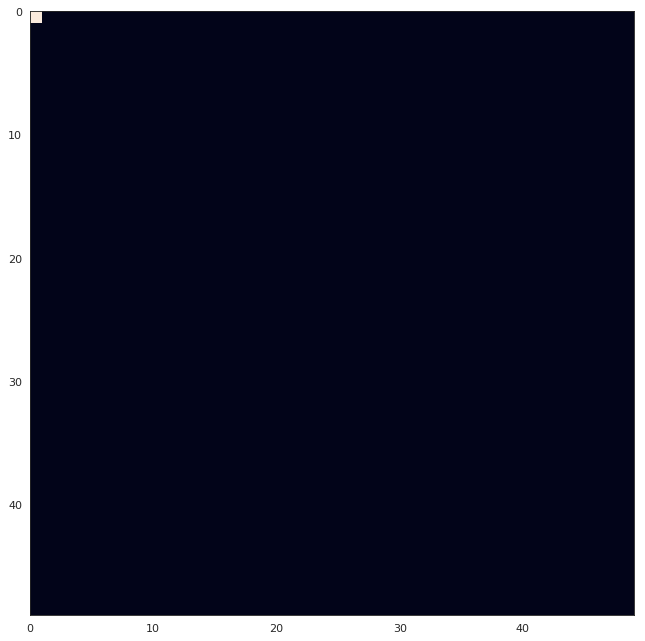


Next step direction: Right
FINAL STATE OF THE HOUSE
Moves made: 26943
########## WELCOME TO MY HOUSE! ###########
It is Random
And be careful, the walls have ears, literally.

👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀💀👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍💀💀👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍

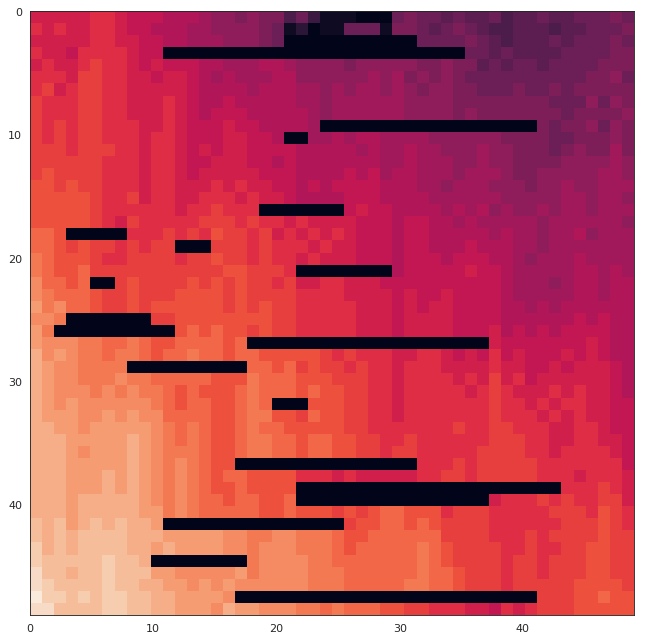

26943

In [12]:
house1 = house_c(obstacles = 20, mess = "Random", dimensions  =(50, 50)) 
house1.spawn_house()


roomba1 = roomba(house = house1, delay = 1, start = (0,0),wall_walking =True, 
                 random_bounce = True, minimum_visits = True)
roomba1.clean(clean_level=0, focus =True, blink =False, heatmap = True, out_steps=10000000)